In [1]:
import re
from collections import namedtuple
from pathlib import Path

from ultralytics import YOLO

# Ruleset
Setup testing rule sets

In [93]:
# -1: no detection, 0: cup, 1: timmies cup 2: either
test_ruleset_QA_03 = {
    "color": [1, 2, 0],
    "special_parts": [1],
    "logo": [1, 0],
    "texture": [1],
    "combinations": [1, 0, 2, 1, 1, 1, 2, 1, 2, 2]
}

rpattern_QA_03 = r"(?P<aspect>[A-Za-z_]+)(?P<requirement>\d+)(?:_(?P<feature>[A-Za-z_]+))?(?:_(?P<index>\d+))?\.jpg"


def eval_QA_03(pimg, model):
    match = re.match(rpattern_QA_03, pimg.name)
    if match:
        d = match.groupdict()
        det = model(pimg, verbose=False)
        expected = test_ruleset_QA_03[d["aspect"]][int(d["requirement"]) - 1]
        if det and len(det) == 1:
            ncls = det[0].boxes.cls[0].item()
            if ncls == expected or expected == 2:
                return (True, f"predicted: {ncls}, {expected=}", det[0])
            else:
                return (False, f"predicted: {ncls}, {expected=}", det[0])
        else:
            if (expected == -1):
                return (True, "expected no detection", None)
            else:
                return (False, f"no prediction, {expected=}", None)
    else:
        return (False, "invalid test image filename", None)


def eval_QA_01(pimg, model):
    det = model.predict(pimg, verbose=False, conf=0.5)
    if len(det[0].boxes.data) != 0:
        return (False, "should not detect", det[0])
    else:
        return (True, "", None)


Testset = namedtuple("Testset", ["path", "eval"])

test01 = Testset(Path("../qa/QA_01"), eval_QA_01)
test03 = Testset(Path("../qa/QA_03"), eval_QA_03)

# Argument

In [94]:
# model to be evaluated
model = YOLO("../runs/detect/train/weights/best.pt")

# set current test evaluation function
current_test = test01

# Test

In [95]:
test_imgs = list(current_test.path.glob("**/*.jpg"))
test_imgs[:5]

[PosixPath('../qa/QA_01/both/IMG_20250318_152636.jpg'),
 PosixPath('../qa/QA_01/both/IMG_20250318_152623.jpg'),
 PosixPath('../qa/QA_01/both/IMG_20250318_152631.jpg'),
 PosixPath('../qa/QA_01/both/IMG_20250318_152721.jpg'),
 PosixPath('../qa/QA_01/both/IMG_20250318_152643.jpg')]

In [96]:
tests = []
for idx, img in enumerate(test_imgs):
    result, msg, pred = current_test.eval(img, model)
    print(f"[{idx:3}] {img.name:<30} {'PASS' if result else '*FAIL*':12} {msg=}")
    tests.append((result, msg, pred))

[  0] IMG_20250318_152636.jpg        *FAIL*       msg='should not detect'
[  1] IMG_20250318_152623.jpg        *FAIL*       msg='should not detect'
[  2] IMG_20250318_152631.jpg        *FAIL*       msg='should not detect'
[  3] IMG_20250318_152721.jpg        *FAIL*       msg='should not detect'
[  4] IMG_20250318_152643.jpg        *FAIL*       msg='should not detect'
[  5] IMG_20250318_152723.jpg        *FAIL*       msg='should not detect'
[  6] IMG_20250318_152653.jpg        *FAIL*       msg='should not detect'
[  7] IMG_20250318_152719.jpg        *FAIL*       msg='should not detect'
[  8] IMG_20250318_152648.jpg        *FAIL*       msg='should not detect'
[  9] IMG_20250318_152701.jpg        *FAIL*       msg='should not detect'
[ 10] IMG_20250318_152717.jpg        *FAIL*       msg='should not detect'
[ 11] IMG_20250318_152706.jpg        *FAIL*       msg='should not detect'
[ 12] IMG_20250318_152639.jpg        *FAIL*       msg='should not detect'
[ 13] QA_01_sleeve_9.jpg             P

# Inspect Specific Test Case

In [97]:
from PIL import Image


def inspect(idx):
    print(f"[{idx:3}] {'PASS' if tests[idx][0] else '*FAIL*':12} {tests[idx][1]}")
    display(Image.fromarray(tests[idx][2].plot()[:, :, ::-1]))

In [98]:
tests[0][2].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.9468])
data: tensor([[377.4375, 211.9705, 907.7242, 703.7284,   0.9468,   1.0000]])
id: None
is_track: False
orig_shape: (960, 1280)
shape: torch.Size([1, 6])
xywh: tensor([[642.5809, 457.8495, 530.2867, 491.7579]])
xywhn: tensor([[0.5020, 0.4769, 0.4143, 0.5122]])
xyxy: tensor([[377.4375, 211.9705, 907.7242, 703.7284]])
xyxyn: tensor([[0.2949, 0.2208, 0.7092, 0.7331]])

[ 40] *FAIL*       should not detect


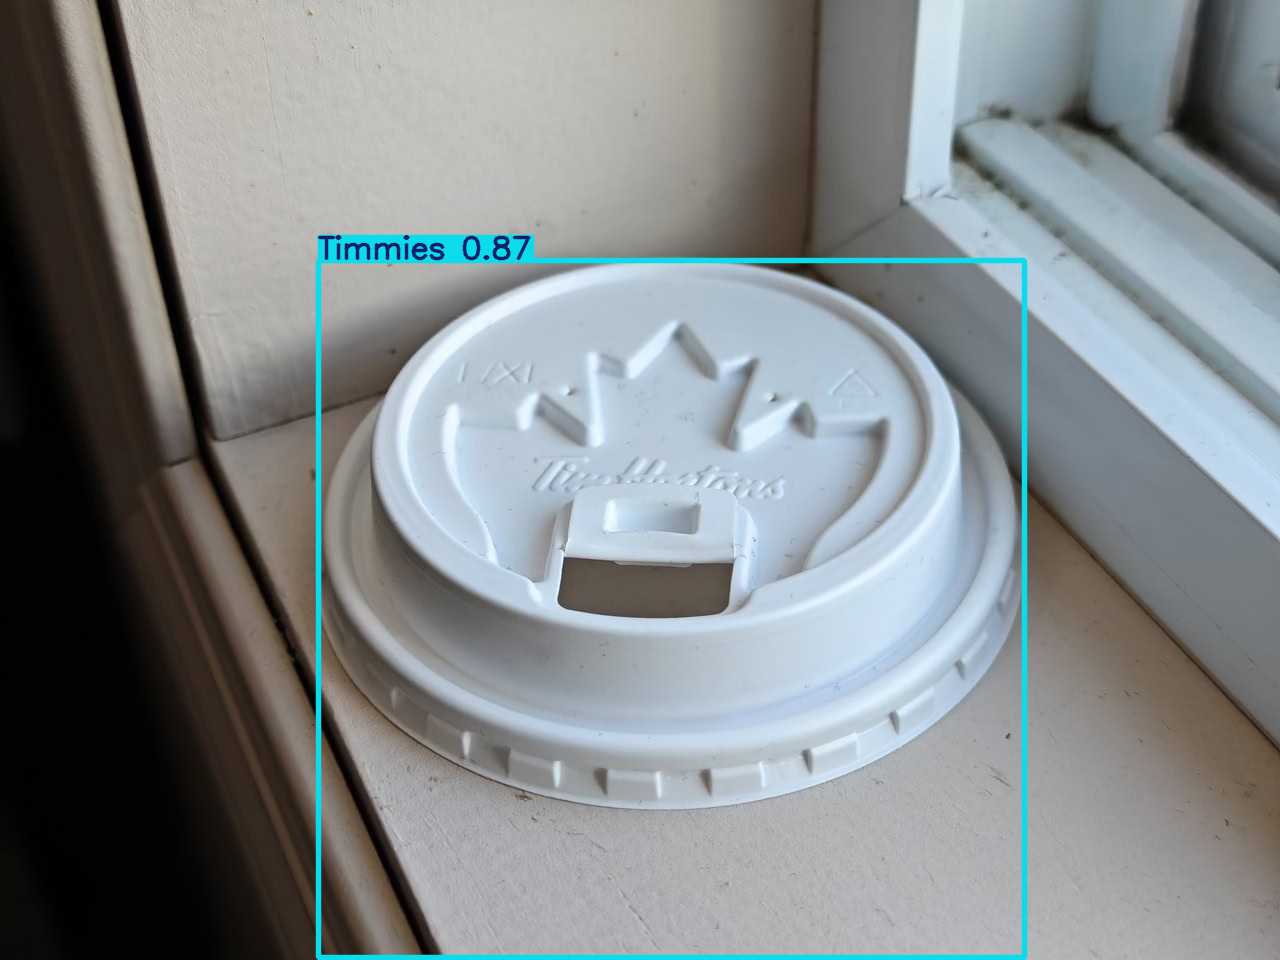

In [101]:
inspect(40)